# E3 카메라 스티커 앱 만들기 (고양이 수염)

#### 프로젝트 개요



### Step 1. 스티커 구하기 

* 고양이 수염 이미지 다운받기 
* 셀카 촬영하기 (프로그램이 본인 사진을 인지 못해서 노드 저자의 사진을 이용했습니다.)

### Step 2. 얼굴 검출 & 랜드마크 검출 하기
오늘 배운 dlib을 이용해서 얼굴의 bounding box 위치와 landmark의 위치를 찾아주세요.

#### 2-1. 필요한 모듈 설치 

In [18]:
#!pip install opencv-python
#!pip install cmake
#!pip install dlib

import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib
import os

#### 2-2. OpenCV로 이미지 읽기

(450, 800, 3)


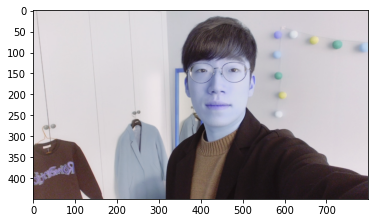

In [19]:
# OpenCV로 이미지 읽기
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/Catface.png'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
print(img_bgr.shape)
plt.imshow(img_bgr)
plt.show()

#### 2-3. BGR to RGB

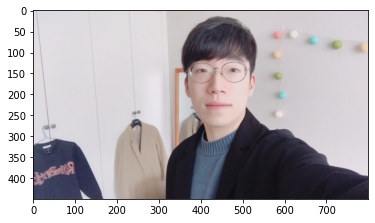

In [20]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

#### 2-4. Hog detector - get bounding box

In [21]:
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
dlib_rects = detector_hog(img_rgb, 1)   #(image, num of img pyramid)
print(dlib_rects) 

rectangles[[(345, 98) (531, 284)]]


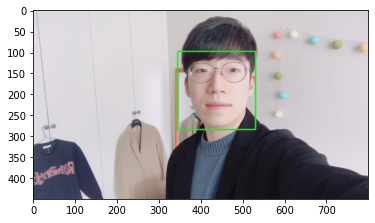

In [22]:
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # img_show (출력용 사진)에 네모

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show() 

#### 2-5.Face landmark
Face landmark와 같이 객체 내부의 점을 찾는 기술을 object keypoint estimation이라고 합니다. keypoint를 찾는 알고리즘은 크게 2가지로 나누어 집니다. 여기서는 1)의 방식을 이용했다. 

1) top-down : bounding box를 찾고 box 내부의 keypoint를 예측      
2) bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

In [23]:
# 모델 불러오기 
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [24]:
# 랜드마크 저장 
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts())) # tuple (x, y) 68개로 이루어진 리스트
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


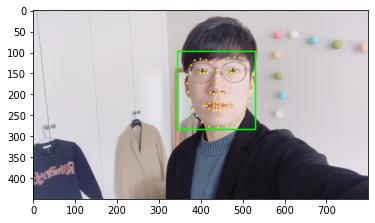

In [25]:
# 출력
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # img_show (출력용 사진)에 point를 노란색으로 그려줘. 

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### Step 3. 스티커 적용위치 확인하기 
볼은 '턱', '눈', '입', '코' 사이에 있다는 점을 이용해 주세요. 비율로 계산하는 방법 잊지 않으셨죠?

#### 3-1. 얼굴에서 좌표 찾아주기 

In [26]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30. x 좌표의 기준점이 된다. 
    print(landmark[1]) # 고양이 왼쪽 수염 맨위의 지점이 올수 있는 y 좌표의 기준점이 된다. 
    x = landmark[30][0]
    y = landmark[1][1] 
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(437, 182)
(368, 174)
(x,y) : (437,174)
(w,h) : (187,187)


#### 3-2. 스티커 사이즈 조정 및 스티커 이미지를 통해 수염 크기, 위치 파악

(187, 187, 3)


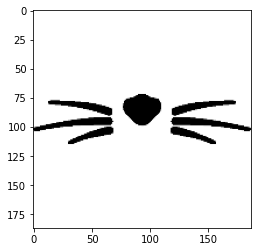

In [27]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)
plt.imshow(img_sticker)
plt.show()

#### 3-3. 스티커 위치 설정
스티커의 시작점으로 스티커의 top-left 좌표로 잡았다 (refined x, refined y). 위의 그림에서 볼 수 있듯이 고양이 왼쪽 수염은 75 정도에서 시작한다 (높이). 수염의 중간 코 부분은 이미지의 중앙에 위치한다. 
* refined x: 위에서 x 좌표는 코 인덱스 30의 x 좌표와 같게 설정했다. 코는 초록박스 중간 지점에 위치한다. 따라서, 스티커 top-left의 x좌표는 왼쪽으로 width 의 1/2 정도 이동시켰다. 
* refined y: 위에서 y 좌표는 고양이 왼쪽 수염 정도의 높이에 설정했다. 왼쪽 수염은 고양이 수염 이미지에서 75 정도에서 시작하므로, 스티커 top-left의 y 좌표는 75 위쪽으로 이동시켰다. 

In [28]:
refined_x = x - w // 2  # left
refined_y = y  - 75      # top
print ('(top-left x, top-left y) : (%d,%d)'%(refined_x, refined_y)) #스티커 top-left 좌표 
print ('(bottom-right x, bottom-right y) : (%d,%d)'%(refined_x+187, refined_y+187))

(top-left x, top-left y) : (344,99)
(bottom-right x, bottom-right y) : (531,286)


### Step 4. 스티커 적용하기

#### 4-1. 스티커 붙이기 
* 스티커 구역은 (344,99) 에서 (531,286)로 설정
* np.where를 통해 img_sticker 가 255(white) 인 부분은 sticker_area를 사용하고 255(white) 아닌 부분을 img_sticker를 사용하시면 됩니다. 

In [29]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) # img_sticker==255으로 바꿔줘야 한다. 

#### 4-2. 스티커 붙은 사진 출력

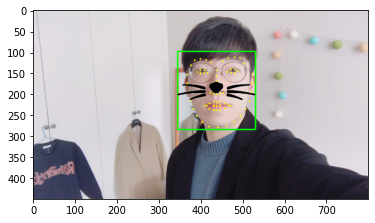

In [30]:
img_show_final = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_final)
plt.show()